# Demo of 3D Segmentation with UNet

In [1]:
pip install monai

Note: you may need to restart the kernel to use updated packages.


## Setup environment

In [1]:
import monai
import matplotlib
%matplotlib inline

/home/lhb/anaconda3/envs/maeve/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Setup imports

In [2]:
import glob
import logging
import os
import time
import matplotlib.pyplot as plt

import nibabel as nib
import numpy as np
from monai.config import print_config
from monai.data import ArrayDataset, create_test_image_3d, decollate_batch, DataLoader
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.nets import UNet, AttentionUnet
from monai.transforms import (
    Compose,
    LoadImage,
    EnsureChannelFirst,
    NormalizeIntensity,
    Activations,
    AsDiscrete,
)
from monai.utils import first, set_determinism
import torch

print_config()

MONAI version: 1.3.0
Numpy version: 1.24.3
Pytorch version: 1.12.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: /home/<username>/anaconda3/envs/maeve/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.1.0
scikit-image version: 0.21.0
scipy version: 1.10.1
Pillow version: 9.4.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.13.1
tqdm version: 4.66.1
lmdb version: 1.4.1
psutil version: 5.9.0
pandas version: 2.0.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For 

## Set deterministic training for reproducibility

In [3]:
set_determinism(seed=0)

## Setup data directory

In [4]:
root_dir = "/home/lhb/Desktop/Homework/data"
print(root_dir)

/home/lhb/Desktop/Homework/data


## Setup logging

In [5]:
log_file = os.path.join(root_dir, "demo.log")
logging.basicConfig(filename=log_file, level=logging.INFO, format="%(asctime)s -  %(message)s")
logger = logging.getLogger()

## Setup demo data

In [6]:
for i in range(40):
    im, seg = create_test_image_3d(128, 128, 128, num_seg_classes=1)

    n = nib.Nifti1Image(im, np.eye(4))
    nib.save(n, os.path.join(root_dir, f"im{i}.nii.gz"))

    n = nib.Nifti1Image(seg, np.eye(4))
    nib.save(n, os.path.join(root_dir, f"seg{i}.nii.gz"))

images = sorted(glob.glob(os.path.join(root_dir, "im*.nii.gz")))
segs = sorted(glob.glob(os.path.join(root_dir, "seg*.nii.gz")))

## Setup transforms, dataset

In [7]:
# Define transforms for image and segmentation
train_imtrans = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        NormalizeIntensity(nonzero=True, channel_wise=True),
    ]
)
train_segtrans = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
    ]
)
val_imtrans = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        NormalizeIntensity(nonzero=True, channel_wise=True),
    ]
)
val_segtrans = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
    ]
)

# Define nifti dataset, dataloader
train_ds = ArrayDataset(images[:30], train_imtrans, segs[:30], train_segtrans)
train_loader = DataLoader(train_ds, batch_size=5, shuffle=True, num_workers=8, pin_memory=torch.cuda.is_available())
val_ds = ArrayDataset(images[30:], val_imtrans, segs[30:], val_segtrans)
val_loader = DataLoader(val_ds, batch_size=5, num_workers=2, pin_memory=torch.cuda.is_available())

# Check data shape and visualize
print(torch.cuda.is_available())
im, seg = first(train_loader)
print(im.shape, seg.shape)

True
torch.Size([5, 1, 128, 128, 128]) torch.Size([5, 1, 128, 128, 128])


## Check data shape and visualize

<function matplotlib.pyplot.show(close=None, block=None)>

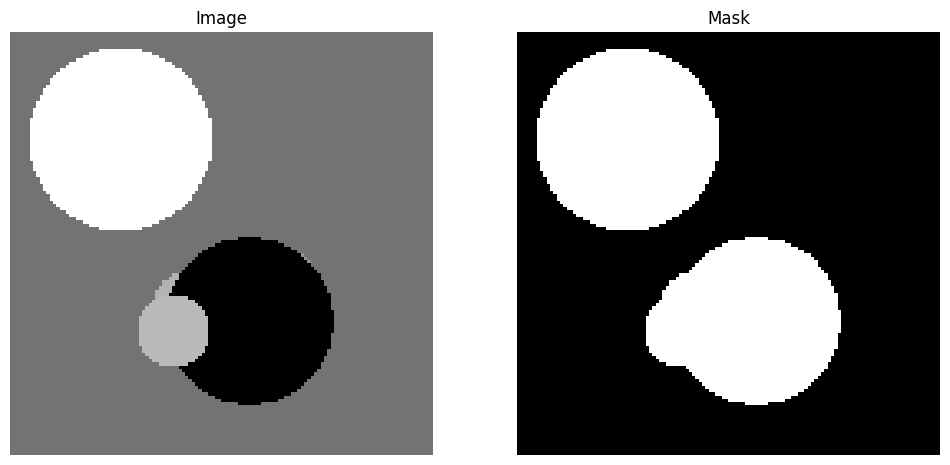

In [8]:
fig = plt.figure("Example image and mask for training", (12, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("Image")
ax1.imshow(im[0,0,:, :, 60].detach().cpu(), cmap="gray")
ax1.axis('off')
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("Mask")
ax2.imshow(seg[0,0,:, :, 60].detach().cpu(), cmap="gray")
ax2.axis('off')
plt.savefig(os.path.join(root_dir, "image_mask.tif"))
plt.show

## Create Model, Loss, Optimizer

In [9]:
max_epochs = 100
val_interval = 1
lr = 1e-4

# Create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda")
# device = torch.device("mps")
# device = torch.device("cpu")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

# model = AttentionUnet(
#     spatial_dims=3,
#     in_channels=1,
#     out_channels=1,
#     channels=(16, 32, 64, 128, 256),
#     strides=(2, 2, 2, 2),
# ).to(device)

loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), lr, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

dice_metric = DiceMetric(include_background=True, reduction="mean")

post_pred = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])
post_label = Compose([AsDiscrete(threshold=0.5)])
    
# Use AMP to accelerate training
if torch.cuda.is_available():
    scaler = torch.cuda.amp.GradScaler()

## Execute a typical PyTorch training process

In [10]:
best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
epoch_metric_values = []
metric_values = []

total_start = time.time()
for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        im, seg = batch_data
        inputs, labels = (
            im.to(device),
            seg.to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        if torch.cuda.is_available():
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    logger.info(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    outputs = [post_pred(i) for i in decollate_batch(outputs)]
    labels = [post_label(i) for i in decollate_batch(labels)]
    dice_metric(y_pred=outputs, y=labels)
    metric = dice_metric.aggregate().item()
    epoch_metric_values.append(metric)

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                im, seg = val_data
                val_inputs, val_labels = (
                    im.to(device),
                    seg.to(device),
                )
                val_outputs = model(val_inputs)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                dice_metric(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            dice_metric.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                torch.save(
                    model.state_dict(),
                    os.path.join(root_dir, "best_metric_model.pth"),
                )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            logger.info(f"epoch {epoch + 1} mean dice: {metric:.4f}")
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")

----------
epoch 1/100
1/6, train_loss: 0.6068, step time: 1.9122
2/6, train_loss: 0.6106, step time: 0.4268
3/6, train_loss: 0.6170, step time: 0.4802
4/6, train_loss: 0.5633, step time: 0.4585
5/6, train_loss: 0.5838, step time: 0.5093
6/6, train_loss: 0.5695, step time: 0.4891
epoch 1 average loss: 0.5918
saved new best metric model
current epoch: 1 current mean dice: 0.3240
best mean dice: 0.3240 at epoch: 1
time consuming of epoch 1 is: 8.6598
----------
epoch 2/100
1/6, train_loss: 0.5670, step time: 0.4884
2/6, train_loss: 0.5735, step time: 0.4140
3/6, train_loss: 0.5642, step time: 0.4128
4/6, train_loss: 0.5645, step time: 0.4139
5/6, train_loss: 0.5234, step time: 0.4162
6/6, train_loss: 0.5297, step time: 0.4751
epoch 2 average loss: 0.5537
saved new best metric model
current epoch: 2 current mean dice: 0.3790
best mean dice: 0.3790 at epoch: 2
time consuming of epoch 2 is: 5.7805
----------
epoch 3/100
1/6, train_loss: 0.5360, step time: 0.4151
2/6, train_loss: 0.5496, ste

2/6, train_loss: 0.4030, step time: 0.4271
3/6, train_loss: 0.4424, step time: 0.4305
4/6, train_loss: 0.4908, step time: 0.4315
5/6, train_loss: 0.4629, step time: 0.4566
6/6, train_loss: 0.4268, step time: 0.4312
epoch 19 average loss: 0.4431
saved new best metric model
current epoch: 19 current mean dice: 0.7842
best mean dice: 0.7842 at epoch: 19
time consuming of epoch 19 is: 5.3241
----------
epoch 20/100
1/6, train_loss: 0.4079, step time: 0.4494
2/6, train_loss: 0.4334, step time: 0.4521
3/6, train_loss: 0.4899, step time: 0.4631
4/6, train_loss: 0.4625, step time: 0.4325
5/6, train_loss: 0.4308, step time: 0.4430
6/6, train_loss: 0.4200, step time: 0.4353
epoch 20 average loss: 0.4407
saved new best metric model
current epoch: 20 current mean dice: 0.7915
best mean dice: 0.7915 at epoch: 20
time consuming of epoch 20 is: 5.0129
----------
epoch 21/100
1/6, train_loss: 0.4790, step time: 0.5101
2/6, train_loss: 0.4325, step time: 0.4450
3/6, train_loss: 0.4244, step time: 0.468

6/6, train_loss: 0.4651, step time: 0.4276
epoch 37 average loss: 0.4195
current epoch: 37 current mean dice: 0.8435
best mean dice: 0.8572 at epoch: 36
time consuming of epoch 37 is: 4.4409
----------
epoch 38/100
1/6, train_loss: 0.3703, step time: 0.4351
2/6, train_loss: 0.4255, step time: 0.4318
3/6, train_loss: 0.3871, step time: 0.4359
4/6, train_loss: 0.4424, step time: 0.4327
5/6, train_loss: 0.4627, step time: 0.4326
6/6, train_loss: 0.4237, step time: 0.4324
epoch 38 average loss: 0.4186
current epoch: 38 current mean dice: 0.8551
best mean dice: 0.8572 at epoch: 36
time consuming of epoch 38 is: 4.4091
----------
epoch 39/100
1/6, train_loss: 0.4059, step time: 0.4354
2/6, train_loss: 0.4455, step time: 0.4311
3/6, train_loss: 0.3775, step time: 0.4306
4/6, train_loss: 0.4223, step time: 0.4301
5/6, train_loss: 0.4407, step time: 0.4332
6/6, train_loss: 0.4150, step time: 0.4332
epoch 39 average loss: 0.4178
current epoch: 39 current mean dice: 0.8563
best mean dice: 0.8572 

2/6, train_loss: 0.4005, step time: 0.4312
3/6, train_loss: 0.3747, step time: 0.4322
4/6, train_loss: 0.4538, step time: 0.4329
5/6, train_loss: 0.4120, step time: 0.4347
6/6, train_loss: 0.4184, step time: 0.4371
epoch 56 average loss: 0.4073
current epoch: 56 current mean dice: 0.8733
best mean dice: 0.8790 at epoch: 53
time consuming of epoch 56 is: 4.3899
----------
epoch 57/100
1/6, train_loss: 0.3686, step time: 0.4362
2/6, train_loss: 0.4412, step time: 0.4346
3/6, train_loss: 0.4238, step time: 0.4333
4/6, train_loss: 0.3891, step time: 0.4353
5/6, train_loss: 0.4378, step time: 0.4313
6/6, train_loss: 0.3812, step time: 0.4362
epoch 57 average loss: 0.4070
saved new best metric model
current epoch: 57 current mean dice: 0.8806
best mean dice: 0.8806 at epoch: 57
time consuming of epoch 57 is: 4.4220
----------
epoch 58/100
1/6, train_loss: 0.3964, step time: 0.4359
2/6, train_loss: 0.3706, step time: 0.4357
3/6, train_loss: 0.4373, step time: 0.4343
4/6, train_loss: 0.4221, s

1/6, train_loss: 0.3957, step time: 0.4366
2/6, train_loss: 0.4321, step time: 0.4338
3/6, train_loss: 0.3769, step time: 0.4328
4/6, train_loss: 0.4105, step time: 0.4350
5/6, train_loss: 0.3863, step time: 0.4369
6/6, train_loss: 0.4108, step time: 0.4328
epoch 75 average loss: 0.4020
current epoch: 75 current mean dice: 0.8843
best mean dice: 0.8886 at epoch: 70
time consuming of epoch 75 is: 4.3742
----------
epoch 76/100
1/6, train_loss: 0.4221, step time: 0.4359
2/6, train_loss: 0.4461, step time: 0.4359
3/6, train_loss: 0.3655, step time: 0.4359
4/6, train_loss: 0.3854, step time: 0.4333
5/6, train_loss: 0.4011, step time: 0.4342
6/6, train_loss: 0.3912, step time: 0.4332
epoch 76 average loss: 0.4019
current epoch: 76 current mean dice: 0.8874
best mean dice: 0.8886 at epoch: 70
time consuming of epoch 76 is: 4.3936
----------
epoch 77/100
1/6, train_loss: 0.3563, step time: 0.4344
2/6, train_loss: 0.4191, step time: 0.4348
3/6, train_loss: 0.3916, step time: 0.4321
4/6, train_

1/6, train_loss: 0.3688, step time: 0.4337
2/6, train_loss: 0.3889, step time: 0.4358
3/6, train_loss: 0.4038, step time: 0.4353
4/6, train_loss: 0.4517, step time: 0.4370
5/6, train_loss: 0.3675, step time: 0.4349
6/6, train_loss: 0.4236, step time: 0.4323
epoch 94 average loss: 0.4007
current epoch: 94 current mean dice: 0.8861
best mean dice: 0.8916 at epoch: 84
time consuming of epoch 94 is: 4.5062
----------
epoch 95/100
1/6, train_loss: 0.3860, step time: 0.4400
2/6, train_loss: 0.3910, step time: 0.4353
3/6, train_loss: 0.3771, step time: 0.4308
4/6, train_loss: 0.3974, step time: 0.4341
5/6, train_loss: 0.4241, step time: 0.4363
6/6, train_loss: 0.4286, step time: 0.4334
epoch 95 average loss: 0.4007
current epoch: 95 current mean dice: 0.8849
best mean dice: 0.8916 at epoch: 84
time consuming of epoch 95 is: 4.4071
----------
epoch 96/100
1/6, train_loss: 0.3986, step time: 0.4375
2/6, train_loss: 0.4059, step time: 0.4324
3/6, train_loss: 0.4452, step time: 0.4321
4/6, train_

## Plot the loss and metric

train completed, best_metric: 0.8933 at epoch: 97, total time: 470.18914914131165.


<function matplotlib.pyplot.show(close=None, block=None)>

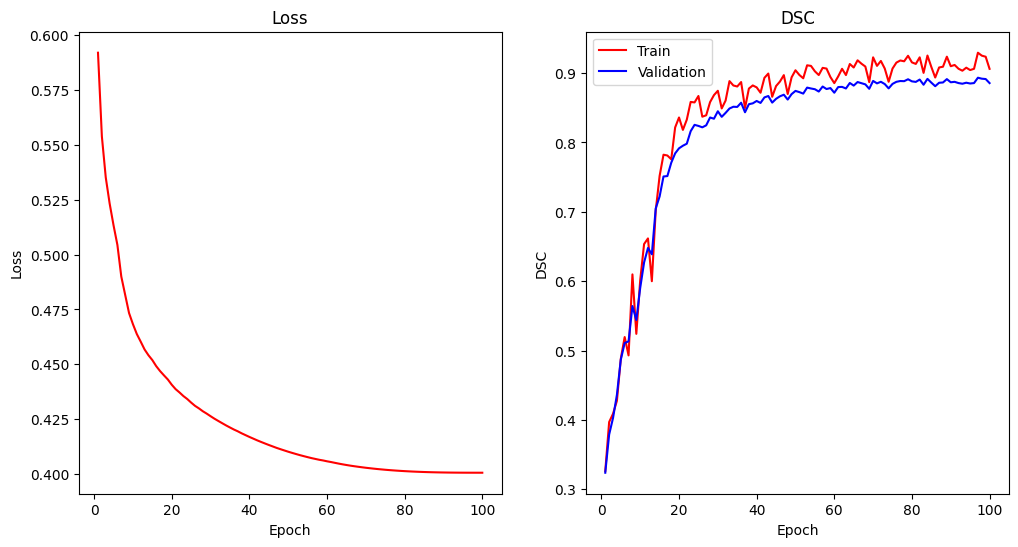

In [11]:
total_time = time.time() - total_start
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}, total time: {total_time}.")
logger.info(
    f"best_metric: {best_metric:.4f} at epoch {best_metric_epoch}, "
    f"total time to train: {total_time}"
    )

fig = plt.figure("Performance in training", (12, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
ax1.plot(x, y, color="red")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("DSC")
x1 = [i + 1 for i in range(len(epoch_loss_values))]
x2 = [val_interval * (i + 1) for i in range(len(metric_values))]
y1 = epoch_metric_values
y2 = metric_values
ax2.plot(x1, y1, color="red")
ax2.plot(x2, y2, color="blue")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("DSC")
ax2.legend(["Train","Validation"])
plt.savefig(os.path.join(root_dir, "performance.tif"))
plt.show

## Check the best model output with the input image and label

<function matplotlib.pyplot.show(close=None, block=None)>

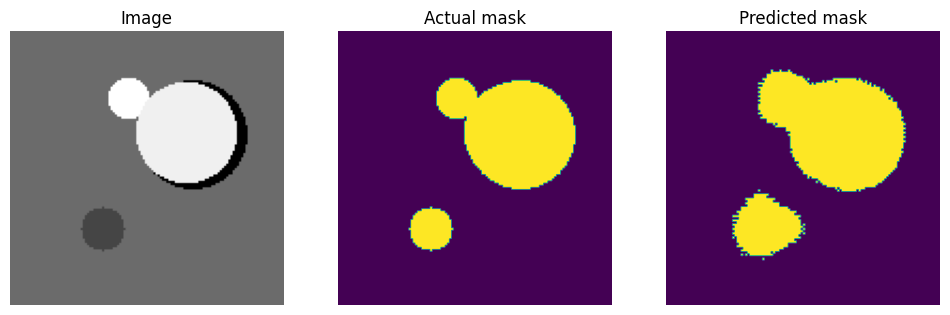

In [12]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    # Select one image to evaluate and visualize the model output
    val_input = val_ds[6][0].unsqueeze(0).to(device)
    val_output = model(val_input)
    val_output = post_pred(val_output[0])

fig = plt.figure("Actual vs. Predicted", (12, 6))
ax1 = fig.add_subplot(1, 3, 1)
ax1.set_title("Image")
ax1.imshow(val_ds[6][0][0,:, :, 70].detach().cpu(), cmap="gray")
ax1.axis('off')
ax2 = fig.add_subplot(1, 3, 2)
ax2.set_title("Actual mask")
ax2.imshow(val_ds[6][1][0,:, :, 70].detach().cpu())
ax2.axis('off')
ax3 = fig.add_subplot(1, 3, 3)
ax3.set_title("Predicted mask")
ax3.imshow(val_output[0,:, :, 70].detach().cpu())
ax3.axis('off')
plt.savefig(os.path.join(root_dir, "actual_predicted.tif"))
plt.show